# YOLO検討ノート

In [2]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [4]:
cv2.__version__

'3.1.0'

In [5]:
chainer.__version__

'1.22.0'

## ネットワーク構成

In [6]:
xp = np

N_BOXES = 1
N_CLASSES = 26  # 0..25
                # F.softmax_cross_entropy()で扱うラベルが
                # 0始まりの必要があるため、便宜的に0を追加
N_GRID = 7
INPUT_SIZE = 448
N_CNN_LAYER = 7

In [7]:
(N_GRID**2) * ((N_BOXES * 5) + N_CLASSES)

1519

In [8]:
class YoloClassifier(chainer.Chain):
    def __init__(self, gpu=-1):
        super(YoloClassifier, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6  = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7  = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            # addditonal layers for pretraining
            conv8  = L.Convolution2D(None, N_CLASSES, ksize=1, stride=1, pad=0),
        )
        self.train = False
        self.gpu = gpu
        if self.gpu >= 0: self.to_gpu()

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        # additional layers for pretraining
        h = self.conv8(h)
        h = F.average_pooling_2d(h, h.data.shape[-1], stride=1, pad=0)
        # reshape result tensor
        h = F.reshape(h, (batch_size, -1))
        return h

    def __call__(self, x, t):
        h = self.forward(x)
        self.loss = F.softmax_cross_entropy(h, t)
        self.accuracy = F.accuracy(h, t)
        if self.train:
            return self.loss
        else:
            return F.softmax(h)

In [9]:
class YoloDetector(chainer.Chain):
    def __init__(self, gpu=-1):
        super(YoloDetector, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6 = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv8 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv9 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            fc1 = L.Linear(50176, 256), # (1024,7,7)=50176
            fc2 = L.Linear(None, 4096),
            fc3 = L.Linear(None, ((N_BOXES*5)+N_CLASSES) * (N_GRID**2))
        )
        self.train = False
        self.class_prob_thresh = 0.3
        self.iou_thresh = 0.3
        self.gpu = gpu
        if self.gpu >= 0: self.to_gpu()

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        h = F.leaky_relu(self.conv8(h), slope=0.1)
        h = F.leaky_relu(self.conv9(h), slope=0.1)
        h = F.leaky_relu(self.fc1(h), slope=0.1)
        h = F.dropout(h, train=self.train, ratio=0.5)
        h = F.leaky_relu(self.fc2(h), slope=0.1)
        h = self.fc3(h)
        # reshape predicted tensor
        h = F.reshape(h, (batch_size, (5*N_BOXES)+N_CLASSES, N_GRID, N_GRID))
        return h

    def __call__(self, x, t):
        # 推論を実行
        px, py, pw, ph, pconf, pprob = self.forward(x)
        # 教師データを抽出
        if self.gpu >= 0: t.to_cpu()
        tx, ty, tw, th, tconf, _tprob = np.array_split(t.data, indices_or_sections=(1,2,3,4,5), axis=1)
#        tx, ty, tw, th, tconf, tprob = F.split_axis(t, indices_or_sections=(1,2,3,4,5), axis=1)
        if self.gpu >= 0: t.to_gpu()

        # オブジェクトが存在しないグリッドは、活性化後にグリッド中心となるよう学習
        tx[tconf != 1.0] = 0.5
        ty[tconf != 1.0] = 0.5
        # オブジェクトが存在しないグリッドは、学習させない
        if self.gpu >= 0: pprob.to_cpu()
        tprob = pprob.data.copy()
        if self.gpu >= 0: pprob.to_gpu()
        tprob[_tprob == 1.0] = 1.0
        # 学習係数を、オブジェクトが存在するグリッドか否かで調整
        box_learning_scale = np.tile(0.1, tconf.shape)
        box_learning_scale[tconf == 1.0] = 5.0
        conf_learning_scale = np.tile(0.5, tconf.shape)
        conf_learning_scale[tconf == 1.0] = 1.0
        prob_learning_scale = np.tile(0.0, tconf.shape)
        prob_learning_scale[tconf == 1.0] = 1.0

        # 損失誤差を算出
        tx = self.__variable(tx, np.float32)
        ty = self.__variable(ty, np.float32)
        tw = self.__variable(tw, np.float32)
        th = self.__variable(th, np.float32)
        tconf = self.__variable(tconf, np.float32)
        tprob = self.__variable(tprob, np.float32)
        if self.gpu >=0:
            tx.to_gpu(), ty.to_gpu(), tw.to_gpu(), th.to_gpu(), tconf.to_gpu(), tprob.to_gpu()
        box_learning_scale = self.__variable(box_learning_scale, np.float32)
        conf_learning_scale = self.__variable(conf_learning_scale, np.float32)
        prob_learning_scale = self.__variable(prob_learning_scale, np.float32)
        if self.gpu >=0:
            box_learning_scale.to_gpu(), conf_learning_scale.to_gpu(), prob_learning_scale.to_gpu()

#        print(type(tx), tx.shape, type(px), px.shape)
        x_loss = F.sum(box_learning_scale * ((tx - px) ** 2))
        y_loss = F.sum(box_learning_scale * ((ty - py) ** 2))
        w_loss = F.sum(box_learning_scale * ((tw - pw) ** 2))
        h_loss = F.sum(box_learning_scale * ((th - ph) ** 2))
        conf_loss = F.sum(conf_learning_scale * ((tconf - pconf) ** 2))
        prob_loss = F.sum(prob_learning_scale * F.reshape(F.sum(((tprob - pprob) ** 2), axis=1), prob_learning_scale.shape))
#        prob_loss = F.sum((tprob - pprob) ** 2)

        if self.train:
            print("loss x:%f y:%f w:%f h:%f conf:%f prob:%f" %
                  (x_loss.data, y_loss.data, w_loss.data, h_loss.data, conf_loss.data, prob_loss.data))
        self.loss = x_loss + y_loss + w_loss + h_loss + conf_loss + prob_loss

        if self.gpu >= 0:
            px.to_cpu(), py.to_cpu(), pw.to_cpu(), ph.to_cpu(), pconf.to_cpu(), pprob.to_cpu()
        self.detected_boxes = self.__detection(px, py, pw, ph, pconf, pprob)
        if self.gpu >= 0:
            px.to_gpu(), py.to_gpu(), pw.to_gpu(), ph.to_gpu(), pconf.to_gpu(), pprob.to_gpu()

        if self.train:
            return self.loss
        else:
            return self.detected_boxes

    def inference(self, x):
        px, py, pw, ph, pconf, pprob = self.forward(x)
        return self.__detection(px, py, pw, ph, pconf, pprob)

    def __detection(self, px, py, pw, ph, pconf, pprob):
        batch_size = px.data.shape[0]
        _px = F.reshape(px, (batch_size, N_GRID, N_GRID)).data
        _py = F.reshape(py, (batch_size, N_GRID, N_GRID)).data
        _pw = F.reshape(pw, (batch_size, N_GRID, N_GRID)).data
        _ph = F.reshape(ph, (batch_size, N_GRID, N_GRID)).data
        _pconf = F.reshape(pconf, (batch_size, N_GRID, N_GRID)).data
        _pprob = pprob.data

        boxes = []
        for i in range(0, batch_size):
            candidates = self.__select_candidates(
                _px[i], _py[i], _pw[i], _ph[i], _pconf[i], _pprob[i], self.class_prob_thresh)
            winners = self.__nms(candidates, self.iou_thresh)
            boxes.append(winners)
        return boxes

    def __select_candidates(self, px, py, pw, ph, pconf, pprob, class_prob_thresh):
        class_prob_map = pprob * pconf # クラス確率を算出 (N_CLASSES,N_GRID,N_GRID)
        candidate_map = class_prob_map.max(axis=0) > class_prob_thresh # 検出グリッド候補を決定 (N_GRID,N_GRID)
        candidate_label_map = class_prob_map.argmax(axis=0) # 検出グリッド候補のラベルを抽出 (N_GRID,N_GRID)
        candidates = []
        for i in range(0, candidate_map.sum()):
            candidates.append({
                'box': Box(px[candidate_map][i], py[candidate_map][i],
                        pw[candidate_map][i], ph[candidate_map][i]),
                #'conf': pconf[candidate_map][i],
                #'prob': pprob.transpose(1,2,0)[candidate_map][i],
                'objectness': class_prob_map.max(axis=0)[candidate_map][i],
                'label': candidate_label_map[candidate_map][i]
            })
        return candidatess

    def __nms(self, candidates, iou_thresh):
        sorted(candidates, key=lambda x: x['objectness'], reverse=True)
        winners = []

        if len(candidates) == 0:
            return winners

        winners.append(candidates[0]) # 第１候補は必ず採用
        for i in range(1, len(candidates)): # 第２候補以降は上位の候補とのIOU次第
            for j in range(0, i):
                if Box.iou(candidates[i]['box'], candidates[j]['box']) > iou_thresh:
                    break
            else:
                winners.append(candidates[i])
        return winners

    def __variable(self, v, t):
        return chainer.Variable(xp.asarray(v).astype(t))

## 学習データのロード

In [12]:
with open(os.path.join('..', 'cache', 'train_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

599

In [13]:
train_dataset[0]

{u'bounding_boxes': [{u'class': u'1',
   u'height': u'270',
   u'width': u'1139',
   u'x': u'13',
   u'y': u'686'}],
 u'classes': [u'1'],
 u'color_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/1/9/color.bmp',
 u'depth_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/1/9/depth.bmp.bmp',
 u'label_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/1/9/label.bmp',
 u'pattern_id': u'9'}

In [14]:
class Image():
    def __init__(self, path, width, height):
        image = cv2.imread(path)
        self.real_height, self.real_width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.image = cv2.resize(image, (width, height))

In [15]:
class Box():
    def __init__(self, x, y, width, height, clazz=0, objectness=1.0):
        self.left = x
        self.top = y
        self.right = x + width
        self.bottom = y + height
        self.clazz = clazz
        self.objectness = objectness

    @property
    def width(self):
        return self.right - self.left

    @property
    def height(self):
        return self.bottom - self.top

    @property
    def vertex(self):
        return ((self.left, self.top), (self.right-1, self.top),
                (self.left, self.bottom-1), (self.right-1, self.bottom-1))

    def area(self):
        return float(self.width * self.height)

    @classmethod
    def overlap(clazz, box1, box2):
        left = max(box1.left, box2.left)
        top = max(box1.top, box2.top)
        right = min(box1.right, box2.right)
        bottom = min(box1.bottom, box2.bottom)
        width = max(0, right - left)
        height = max(0, bottom - top)
        return Box(left, top, width, height)

    @classmethod
    def intersection(clazz, box1, box2):
        return Box.overlap(box1, box2).area()

    @classmethod
    def union(clazz, box1, box2):
        return box1.area() + box2.area() - Box.intersection(box1, box2)

    @classmethod
    def iou(clazz, box1, box2):
        return Box.intersection(box1, box2) / Box.union(box1, box2)

class GroundTruth():
    def __init__(self, width, height, bounding_boxes=[]):
        self.width = width
        self.height = height
        self.bounding_boxes = bounding_boxes

In [16]:
bounding_boxes = [Box(x=float(box['x']), y=float(box['y']),
                            width=float(box['width']), height=float(box['height']),
                            clazz=float(box['class'])) for box in train_dataset[0]['bounding_boxes']]
bounding_boxes[0]

<__main__.Box instance at 0x11399a998>

In [17]:
image = Image(train_dataset[0]['color_image_path'], INPUT_SIZE, INPUT_SIZE)

In [18]:
image.image[150][380], image.image[380][150]

(array([14,  7, 15], dtype=uint8), array([12, 18, 32], dtype=uint8))

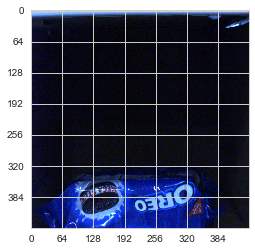

In [19]:
fig, axes = plt.subplots(1,1)
plt.xticks(range(0, 448, 64))
plt.yticks(range(0, 448, 64))
plt.imshow(image.image)
#plt.plot([3*64, 3*64 + 0.117*64], [6*64, 6*64 + 0.052*64], 'r', lw=2)

## 学習データのテンソルを作成

In [20]:
def parse_item_of_dataset(item):
    image = Image(item['color_image_path'], INPUT_SIZE, INPUT_SIZE)
    bounding_boxes = [Box(x=float(box['x']), y=float(box['y']),
                            width=float(box['width']), height=float(box['height']),
                            clazz=int(box['class'])) for box in item['bounding_boxes']]
    ground_truth = GroundTruth(width=image.real_width, height=image.real_height,
        bounding_boxes=bounding_boxes)
    return {'image': image, 'ground_truth': ground_truth}

In [21]:
dataset = filter(lambda item: item['bounding_boxes'] != [], train_dataset)
items = [parse_item_of_dataset(item) for item in dataset]
images = np.asarray([item['image'] for item in items])
ground_truths = np.asarray([item['ground_truth'] for item in items])

In [22]:
images[0], ground_truths[0]

(<__main__.Image instance at 0x113959128>,
 <__main__.GroundTruth instance at 0x11399a0e0>)

In [23]:
def parse_ground_truth(bounding_box, real_width, real_height):
    tw = bounding_box.width * INPUT_SIZE / real_width
    th = bounding_box.height * INPUT_SIZE / real_height
    tx = (bounding_box.left * INPUT_SIZE / real_width) + (tw / 2)
    ty = (bounding_box.top * INPUT_SIZE / real_height) + (th / 2)

    grid_size = INPUT_SIZE / N_GRID
    active_grid_cell = {
        'x': int(math.modf(tx / grid_size)[1]),
        'y': int(math.modf(ty / grid_size)[1])
    }
    norm_truth = { # [0..1] に正規化
        'x' : math.modf(tx / grid_size)[0],
        'y' : math.modf(ty / grid_size)[0],
        'w' : tw / INPUT_SIZE,
        'h' : th / INPUT_SIZE
    }
    one_hot_clazz = np.eye(N_CLASSES)[np.array(bounding_box.clazz)]

    # detection layerのテンソルに変換
    tensor = np.zeros(((5*N_BOXES)+N_CLASSES, N_GRID, N_GRID)).astype(np.float32)
    tensor[:5, active_grid_cell['y'], active_grid_cell['x']] \
        = [norm_truth['x'], norm_truth['y'], norm_truth['w'], norm_truth['h'], 1.0]
    tensor[5:, active_grid_cell['y'], active_grid_cell['x']] = one_hot_clazz
    return tensor

In [24]:
def make_ground_truth_tensor(ground_truth):
    each_tensors = [parse_ground_truth(box, ground_truth.width, ground_truth.height)
                        for box in ground_truth.bounding_boxes]
    return reduce(lambda x, y: x + y, each_tensors)

In [25]:
image_tensors  = np.asarray([image.image for image in images]).transpose(0,3,1,2)
ground_truth_tensors = np.asarray([make_ground_truth_tensor(truth) for truth in ground_truths])

image_tensors.shape, ground_truth_tensors.shape

((599, 3, 448, 448), (599, 31, 7, 7))

## ミニバッチ時の学習データの抽出

In [26]:
batch_size = 10

In [27]:
n_train = len(ground_truths)
n_train

599

In [28]:
perm = np.random.permutation(n_train)
perm[0:5]

array([ 96, 584,  35, 252, 418])

In [29]:
count = 0
ix = perm[count:count+batch_size]
x = chainer.Variable(xp.asarray(image_tensors[ix]).astype(np.float32))
t = chainer.Variable(xp.asarray(ground_truth_tensors[ix]).astype(np.float32))

In [30]:
x.shape, t.shape

((10, 3, 448, 448), (10, 31, 7, 7))

## 検出器のセットアップ

In [31]:
detector_model = YoloDetector()
detector_optimizer = chainer.optimizers.Adam()
detector_optimizer.setup(detector_model)

## 推論を実行

In [32]:
h = detector_model.forward(x)

In [33]:
h2 = F.sigmoid(h)

In [34]:
_px, _py, _pw, _ph, _pconf, _pprob = F.split_axis(h.data, indices_or_sections=(1,2,3,4,5), axis=1)
_px = F.sigmoid(_px).data
_py = F.sigmoid(_py).data
_pw = F.sigmoid(_pw).data
_ph = F.sigmoid(_ph).data
_pconf = F.sigmoid(_pconf).data
_pprob = F.sigmoid(_pprob).data

In [35]:
_px2, _py2, _pw2, _ph2, _pconf2, _pprob2 = np.array_split(h2.data, indices_or_sections=(1,2,3,4,5), axis=1)

In [36]:
_px2[0][0][0][0] = -1
_px2[0][0]

array([[-1.        ,  0.26449409,  0.40429354,  0.55203962,  0.8437103 ,
         0.53183401,  0.50162393],
       [ 0.74272501,  0.3864845 ,  0.90207034,  0.57100129,  0.56750584,
         0.55596542,  0.70820177],
       [ 0.70840454,  0.56450415,  0.56932759,  0.5326938 ,  0.76436532,
         0.64304256,  0.84411895],
       [ 0.3494556 ,  0.25334257,  0.11256179,  0.36393797,  0.88539535,
         0.14458972,  0.60133171],
       [ 0.2588535 ,  0.48346239,  0.34262562,  0.24155867,  0.68575597,
         0.67539829,  0.39958382],
       [ 0.3079794 ,  0.17696244,  0.32431883,  0.8230707 ,  0.36073178,
         0.40743107,  0.22904855],
       [ 0.79281688,  0.58433467,  0.47268945,  0.36289343,  0.6784237 ,
         0.59618896,  0.65911257]], dtype=float32)

In [37]:
h3 = chainer.cuda.to_cpu(h2.data.copy())
h3.shape

(10, 31, 7, 7)

In [38]:
h3[0][0][0][0] = -2.0
h3[0][0]

array([[-2.        ,  0.26449409,  0.40429354,  0.55203962,  0.8437103 ,
         0.53183401,  0.50162393],
       [ 0.74272501,  0.3864845 ,  0.90207034,  0.57100129,  0.56750584,
         0.55596542,  0.70820177],
       [ 0.70840454,  0.56450415,  0.56932759,  0.5326938 ,  0.76436532,
         0.64304256,  0.84411895],
       [ 0.3494556 ,  0.25334257,  0.11256179,  0.36393797,  0.88539535,
         0.14458972,  0.60133171],
       [ 0.2588535 ,  0.48346239,  0.34262562,  0.24155867,  0.68575597,
         0.67539829,  0.39958382],
       [ 0.3079794 ,  0.17696244,  0.32431883,  0.8230707 ,  0.36073178,
         0.40743107,  0.22904855],
       [ 0.79281688,  0.58433467,  0.47268945,  0.36289343,  0.6784237 ,
         0.59618896,  0.65911257]], dtype=float32)

In [39]:
h2.data[0][0]

array([[-1.        ,  0.26449409,  0.40429354,  0.55203962,  0.8437103 ,
         0.53183401,  0.50162393],
       [ 0.74272501,  0.3864845 ,  0.90207034,  0.57100129,  0.56750584,
         0.55596542,  0.70820177],
       [ 0.70840454,  0.56450415,  0.56932759,  0.5326938 ,  0.76436532,
         0.64304256,  0.84411895],
       [ 0.3494556 ,  0.25334257,  0.11256179,  0.36393797,  0.88539535,
         0.14458972,  0.60133171],
       [ 0.2588535 ,  0.48346239,  0.34262562,  0.24155867,  0.68575597,
         0.67539829,  0.39958382],
       [ 0.3079794 ,  0.17696244,  0.32431883,  0.8230707 ,  0.36073178,
         0.40743107,  0.22904855],
       [ 0.79281688,  0.58433467,  0.47268945,  0.36289343,  0.6784237 ,
         0.59618896,  0.65911257]], dtype=float32)

In [40]:
(_pprob == _pprob2).sum(), _pprob.shape

(12740, (10, 26, 7, 7))

In [42]:
x.shape

(10, 3, 448, 448)

In [45]:
h = detector_model.forward(x)
px, py, pw, ph, pconf, pprob = np.array_split(h.data, indices_or_sections=(1,2,3,4,5), axis=1)

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 26, 7, 7))

In [46]:
type(px)

numpy.ndarray

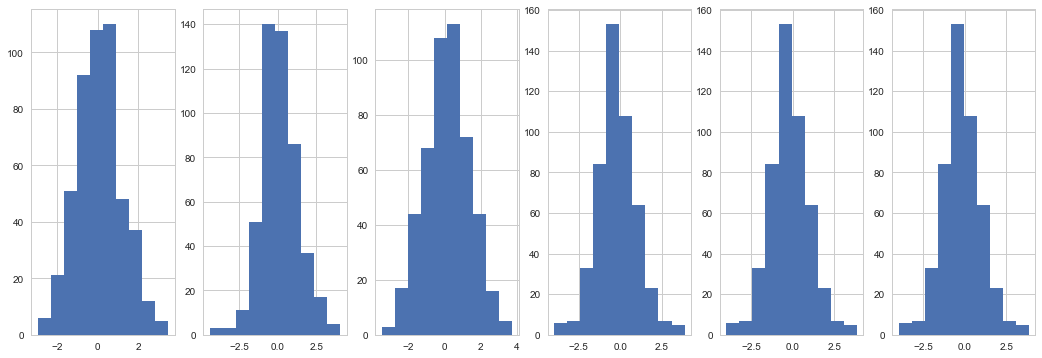

In [48]:
fig, axes = plt.subplots(1, 6, figsize=(18, 6))
axes[0].hist(px.flatten())
axes[1].hist(py.flatten())
axes[2].hist(pw.flatten())
axes[3].hist(ph.flatten())
axes[4].hist(ph.flatten())
axes[5].hist(ph.flatten())
pass

In [49]:
tx, ty, tw, th, tconf, tprob = np.array_split(ground_truth_tensors[0:batch_size], indices_or_sections=(1,2,3,4,5), axis=1)

tx.shape, ty.shape, tw.shape, tconf.shape, tprob.shape

((10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 26, 7, 7))

In [54]:
pprob.shape, tprob.shape

((10, 26, 7, 7), (10, 26, 7, 7))

In [121]:
np.argwhere(np.array([0,0,1,0,0,1,0,0]) > 0)

array([[2],
       [5]])

In [119]:
tprob[0][:,5,3]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [116]:
tprob[0].argmax(axis=0).astype(np.int32)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [96]:
pprob.shape, tprob.shape

((10, 26, 7, 7), (10, 26, 7, 7))

In [113]:
chainer.Variable(tprob.sum(axis=1).astype(np.int32)).shape

(10, 7, 7)

In [114]:
F.softmax_cross_entropy(F.sigmoid(pprob), chainer.Variable(tprob.sum(axis=1).astype(np.int32))).data

array(3.2979605197906494, dtype=float32)

In [112]:
F.softmax_cross_entropy?

In [52]:
np.max(F.sigmoid(tconf).data)

0.7310586

In [53]:
tconf[0]

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]], dtype=float32)

In [ ]:
tx[tconf != 1.0] = 0.5

tx[0]

In [ ]:
np.sum(((tx - px)**2))

In [ ]:
box_learning_scale = np.tile(0.1, tx.shape)
box_learning_scale[tconf == 1.0] = 1.0

box_learning_scale[0]

In [ ]:
(box_learning_scale * ((tx - px)**2)).data[0]

In [ ]:
F.sum(box_learning_scale * ((tx - px)**2)).data

In [ ]:
tprob[0][12,:,:]

In [ ]:
_tprob = pprob.data.copy()
_tprob[tprob == 1.0] = 1.0
_tprob[0][12,:,:]

In [ ]:
((_tprob - pprob)**2).data[0][12,:,:]

In [ ]:
F.sum((_tprob - pprob)**2).data

In [ ]:
_tprob_err = F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)
_tprob_err.data[0]

In [ ]:
prob_learning_scale = np.tile(0.0, tconf.shape)
prob_learning_scale[tconf == 1.0] = 1.0

In [ ]:
F.sum(prob_learning_scale * F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)).data

## 推論結果を検出座標に変換

In [ ]:
_px = F.reshape(px, (batch_size, N_GRID, N_GRID)).data
_py = F.reshape(py, (batch_size, N_GRID, N_GRID)).data
_pw = F.reshape(pw, (batch_size, N_GRID, N_GRID)).data
_ph = F.reshape(ph, (batch_size, N_GRID, N_GRID)).data
_pconf = F.reshape(pconf, (batch_size, N_GRID, N_GRID)).data
_pprob = pprob.data

_px.shape, _py.shape, _pw.shape, _ph.shape, _pconf.shape, _pprob.shape

In [ ]:
_pobj = (_pprob[0] * _pconf[0]).transpose(1,2,0)
_pobj[1,3]

In [ ]:
_class_probs = _pprob[0] * _pconf[0]
_max_class_probs_map = _class_probs.max(axis=0)
_max_class_probs_map

In [ ]:
_candidate_map = _class_probs.max(axis=0) > 0.8
_candidate_label_map = _class_probs.argmax(axis=0)

In [ ]:
_candidate_map

In [ ]:
[{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map == True)]

In [ ]:
_candidate_label_map

In [ ]:
_class_probs.max(axis=0)[_candidate_map]

In [ ]:
_candidate_label_map[_candidate_map]

In [ ]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].max() * _pconf[0][_candidate_map][0]

In [ ]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].argmax()

In [ ]:
def __select_candidates(self, px, py, pw, ph, pconf, pprob, class_prob_thresh):
    class_prob_map = pprob * pconf # クラス確率を算出 (N_CLASSES,N_GRID,N_GRID)
    candidate_map = class_prob_map.max(axis=0) > class_prob_thresh # グリッド候補 (N_GRID,N_GRID)
    candidate_class_map = class_prob_map.argmax(axis=0) # グリッド候補のクラス (N_GRID,N_GRID)
    active_grid_cells = [{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map)] # グリッド候補の位置
    candidates = []
    for i in range(0, candidate_map.sum()):
        candidates.append({
            'box': Box(px[candidate_map][i], py[candidate_map][i],
                       pw[candidate_map][i], ph[candidate_map][i]),
            #'conf': pconf[candidate_map][i],
            #'prob': pprob.transpose(1,2,0)[candidate_map][i],
            'objectness': class_prob_map.max(axis=0)[candidate_map][i],
            'class': candidate_class_map[candidate_map][i],
            'active_grid_cell': active_grid_cells[i]
        })
    return candidates

In [ ]:
def __nms(self, candidates, iou_thresh):
    sorted(candidates, key=lambda x: x['objectness'], reverse=True)
    winners = []

    if len(candidates) == 0:
        return winners

    winners.append(candidates[0]) # 第１候補は必ず採用
    for i in range(1, len(candidates)): # 第２候補以降は上位の候補とのIOU次第
        for j in range(0, i):
            if Box.iou(candidates[i]['box'], candidates[j]['box']) > iou_thresh:
                break
        else:
            winners.append(candidates[i])
    return winners

In [ ]:
i = 0
candidates = __select_candidates(None, _px[i], _py[i], _pw[i], _ph[i], _pconf[i], _pprob[i], 0.9)
winners = __nms(None, candidates, 0.3)

len(candidates), len(winners)

In [ ]:
winners

In [ ]:
def final_detection(result, real_width, real_height):
    grid_size = INPUT_SIZE / N_GRID
    pred_x = (result['box']).left
    pred_y = (result['box']).top
    pred_w = (result['box']).width
    pred_h = (result['box']).height
    active_grid_cell = result['active_grid_cell']
    
    return {
        'x': (active_grid_cell['x'] + pred_x) * grid_size * real_width / INPUT_SIZE,
        'y': (active_grid_cell['y'] + pred_y) * grid_size * real_height / INPUT_SIZE,
        'width': pred_w * real_width,
        'height': pred_h * real_height,
        'class': result['class'],
        'objectness': result['objectness']
    }

In [ ]:
final_detection(winners[0], 1280, 960)

In [ ]:
def check_correct_detection(pred, truths):
    # TODO: pred,truthsをBoxに変換
    best_iou, best_truth = Box.best_iou(pred, truth)
    if best_iou <= 0.5:
        return False
    if pred.class != best_truth.class
        return False
    return True

In [ ]:
positives = {str(i): {'true': 0, 'false': 0}  for i in range(0, N_CLASSES)}

In [ ]:
positives.items()

In [ ]:
def precision(tp, fp):
    if tp == 0 and fp == 0:
        return 0
    else:
        return float(tp) / (tp + fp)
            

average_precisions = {str(p[0]): precision(p[1]['true'], p[1]['false']) for p in positives.items()}

len(average_precisions.values())

In [ ]:
import six
for count in six.moves.range(0, 149, 10):
    print (count)


### モニタリングする指標
- 検出数
- mean average precision

In [ ]:
arr = np.asarray([Box(1,2,3,4), Box(5,6,7,8)])
type(arr)

In [ ]:
np.savez('foo.npz', data=arr)
arr2 = np.load('foo.npz')

for box in arr2['data']:
    print (box.vertex[0], box.width, box.height)

### Boxクラス
- x
- y
- width
- height

### Ground Truthクラス
- width
- height
- bounding_boxes
  - box
  - class
  - objectness


In [ ]:
[x + 1
    for x in np.arange(0,5)]

In [ ]:
np.random.rand((1,3,5,5)).shape

In [ ]:
a = np.arange(1, 6)
a[1:]

In [ ]:
for i, item in enumerate(a[1:], 1):
    print(i, item)

In [ ]:
b = np.arange(11, 16)
b

In [ ]:
for i, (a, b) in enumerate(zip(a, b), 1):
    print (i, a, b)

In [ ]:
np.sort(b)[::-1]

In [ ]:
import itertools
for _a, _b in itertools.product(a, b):
    print(_a, _b)

In [ ]:
a = [1,2,3,4,5]
type(a)

In [ ]:
a = [0.2, 0.1, 0.5, 0.9, 0.8]
np.asarray(a).mean()

In [ ]:
750 * (3.5+3.5)

In [ ]:
loss = chainer.Variable(xp.asarray([0.]).astype(np.float32))
loss.data

In [ ]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h.data, indices_or_sections=(1,2,3,4,5), axis=1)

In [ ]:
h2 = h.data.copy()
h2.shape

In [ ]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h2, indices_or_sections=(1,2,3,4,5), axis=1)

In [ ]:
px[0][0][_candidate_map]

In [ ]:
px0 = px[0]
px0.shape

In [ ]:
px0 = px0.reshape(px0.shape[1:])
px0.shape

In [ ]:
a = F.sum(xp.asarray([1.0]))
a.data

In [ ]:
np.reshape?

In [ ]:
h2.shape

In [ ]:
h3 = h2[0]
h3.shape

In [ ]:
px, py, pw, ph, pconf, pprob \
        = np.array_split(h3, indices_or_sections=(1,2,3,4,5), axis=0)
px.shape

In [ ]:
np.tile(True, (N_GRID, N_GRID))

In [ ]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return '<Point x:%4.1f y:%4.1f>' % (self.x, self.y)

In [ ]:
grid_cells = [Point(x=float(point[1]), y=float(point[0]))
                for point in np.argwhere(np.tile(True, (N_GRID, N_GRID)))]

In [ ]:
grid_cells

In [115]:
int(True), int(False)

(1, 0)

In [144]:
math.log10(20 - 18) / math.log10(20)

0.23137821315975918